In [17]:
import os
import random
import argparse
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from utils import make_dirs, load_data, standardization, train_validate_test_split, SequenceDataset, predict, inverse_transform, calculate_metrics
from models import RNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
# 指定系统中已安装的中文字体，例如SimSun或Microsoft YaHei
plt.rcParams['font.family'] = 'SimSun'

# 如果您需要显示中文标签，可以设置以下参数
plt.rcParams['axes.unicode_minus'] = False  # 处理坐标轴负号显示问题

In [2]:
num_epochs = 20
which_data='./data/data.xlsx'
seed = 7777
output_size = 1
seq_length = 5
batch_size = 128
target='electricity_price (PLN/MWh)'
feature = ['date', 
                                  'electricity_price (PLN/MWh)',
                                  'energy_demand (MW)',
                                  'energy_from_wind_sources (MW)', 
                                  'is_holiday',
                                  'code_of_the_day', 
                                  'electricity_price (PLN/MWh) lag24', 
                                  'electricity_price (PLN/MWh) lag48', 
                                  'electricity_price (PLN/MWh) lag72',
                                  'electricity_price (PLN/MWh) lag96',
                                  'electricity_price (PLN/MWh) lag120', 
                                  'electricity_price (PLN/MWh) lag144', 
                                  'electricity_price (PLN/MWh) lag168',
                                  'electricity_price (PLN/MWh) lag336', 
                                  'energy_demand (MW) lag24', 
                                  'energy_demand (MW) lag48',
                                  'energy_demand (MW) lag72', 
                                  'energy_demand (MW) lag96',
                                  'energy_demand (MW) lag120', 
                                  'energy_demand (MW) lag144',
                                  'energy_demand (MW) lag168', 
                                  'energy_demand (MW) lag336',
                                  'energy_from_wind_sources (MW) lag24',
                                  'energy_from_wind_sources (MW) lag48',
                                  'energy_from_wind_sources (MW) lag72',
                                  'energy_from_wind_sources (MW) lag96',
                                  'energy_from_wind_sources (MW) lag120',
                                  'energy_from_wind_sources (MW) lag144',
                                  'energy_from_wind_sources (MW) lag168',
                                  'energy_from_wind_sources (MW) lag336']
test_split=0.0824
lr = 0.0001
num_hidden_size = 256

hidden_size = 128
num_layers = 2
dropout = 0.6
model=['rnn', 'lstm', 'gru'][2]

In [3]:
# Fix seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
# Prepare data 
df = load_data(which_data)[feature]
df = df.set_index(['date'])  
features = list(df.columns.difference([target]))
target_mean = df[target].mean()
target_stdev = df[target].std()

In [5]:
# Standardize data 
df_ = standardization(df, target)
df = df_.reset_index(drop=False)

In [6]:
#Split data
df_train, df_val, df_test = train_validate_test_split(df, test_split) 
df_train = df_train.set_index(['date'])  # (21888, 29)
df_val = df_val.set_index(['date'])  # (2159, 29)
df_test = df_test.set_index(['date'])  # (2160, 29)

In [7]:
train_dataset = SequenceDataset(
    df_train,
    target=target,    
    features=features,
    sequence_length=seq_length
)

val_dataset = SequenceDataset(
    df_val,
    target=target,  
    features=features,
    sequence_length=seq_length
)

test_dataset = SequenceDataset(
    df_test,
    target=target,   
    features=features,
    sequence_length=seq_length
)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
num_inputs=len(features)

In [19]:
class GRU(nn.Module):
    def __init__(self, num_features, hidden_units, num_layers, output_size, dropout_rate):
        super(GRU, self).__init__()
        self.num_features = num_features 
        
        # 定义层数和每层的节点数
        self.hidden_units = hidden_units
        self.num_layers = num_layers       
        self.output_size = output_size
        self.dropout = dropout_rate

        # GRU层
        self.gru = nn.GRU(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout_rate           
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=self.output_size)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, hn = self.gru(x, h0)
                
        out = self.linear(hn[0]).flatten()  # Hn的第一个维度是num_layers，在上面设置为1
        return out

In [21]:
model = GRU(num_inputs, hidden_size, num_layers, output_size, dropout)

In [22]:
train_losses = []  # 存储每个epoch的训练损失
val_losses = []    # 存储每个epoch的验证损失

# num_epochs = 20

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for ix_epoch in range(1, num_epochs+1):
    print(f"Epoch {ix_epoch}\n---------")
    
    # 训练阶段
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  # 累加每个批次的训练损失
    
    # 验证阶段
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()  # 累加每个批次的验证损失
    
    # 计算平均损失
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    # 记录每个epoch的训练和验证损失
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    print()


Epoch 1
---------
Train Loss: 0.5296 | Validation Loss: 0.1152

Epoch 2
---------
Train Loss: 0.2488 | Validation Loss: 0.1106

Epoch 3
---------
Train Loss: 0.2118 | Validation Loss: 0.1047

Epoch 4
---------
Train Loss: 0.1981 | Validation Loss: 0.0993

Epoch 5
---------
Train Loss: 0.1896 | Validation Loss: 0.0965

Epoch 6
---------
Train Loss: 0.1830 | Validation Loss: 0.0935

Epoch 7
---------
Train Loss: 0.1777 | Validation Loss: 0.0902

Epoch 8
---------
Train Loss: 0.1732 | Validation Loss: 0.0879

Epoch 9
---------
Train Loss: 0.1690 | Validation Loss: 0.0867

Epoch 10
---------
Train Loss: 0.1651 | Validation Loss: 0.0873

Epoch 11
---------
Train Loss: 0.1619 | Validation Loss: 0.0821

Epoch 12
---------
Train Loss: 0.1587 | Validation Loss: 0.0799

Epoch 13
---------
Train Loss: 0.1551 | Validation Loss: 0.0809

Epoch 14
---------
Train Loss: 0.1523 | Validation Loss: 0.0805

Epoch 15
---------
Train Loss: 0.1493 | Validation Loss: 0.0800

Epoch 16
---------
Train Loss: 0.1

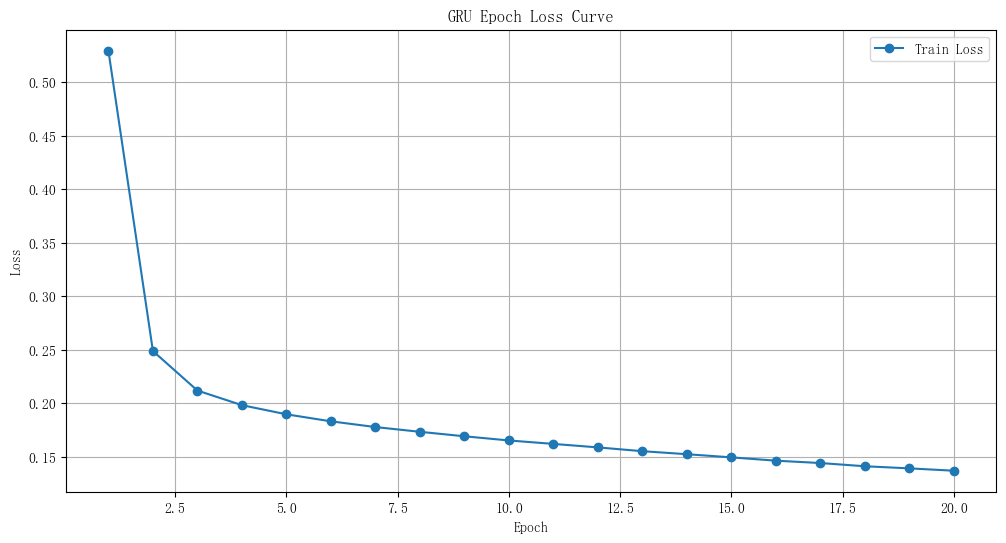

In [23]:
# 绘制损失曲线
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
# plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU Epoch Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [24]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_val[ystar_col] = predict(val_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()
# 将训练集、验证集和测试集的结果合并成一个DataFrame，并只保留目标列和模型预测列
df_out = pd.concat((df_train, df_val, df_test))[[target, ystar_col]]

# 对模型的预测结果进行逆转换，将其还原为原始数据的尺度
df_pred = inverse_transform(df_out, target_stdev,  target_mean)

result_metrics = calculate_metrics(df_pred, target, ystar_col)
print(result_metrics)

{'mae': 14.106479861316629, 'rmse': 21.78102432742105, 'r2': 0.8710059197865522, 'mape': 6.650308143998294}


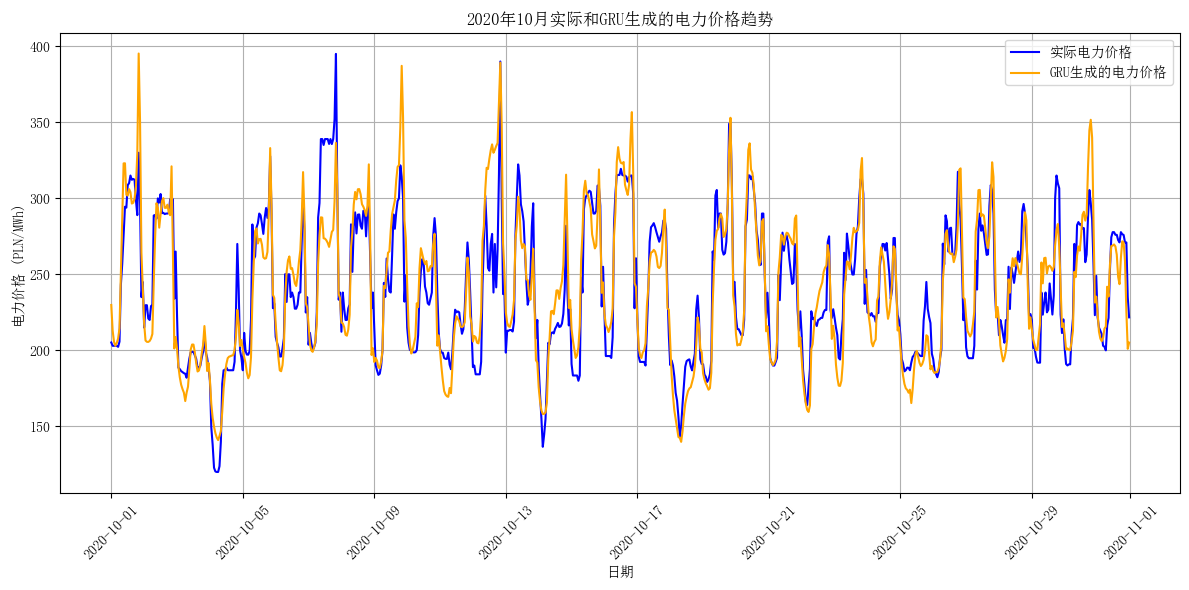

In [25]:
import matplotlib.pyplot as plt

# 筛选出2020年10月的数据
october_data = df_pred['2020-10-01':'2020-10-31']

# 提取实际电力价格和GRU生成的电力价格
actual_prices = october_data['electricity_price (PLN/MWh)']
predicted_prices = october_data['model forecast']

# 创建日期索引
dates = october_data.index
# 绘制电力价格趋势图
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='实际电力价格', color='blue')
plt.plot(dates, predicted_prices, label='GRU生成的电力价格', color='orange')
plt.xlabel('日期')
plt.ylabel('电力价格 (PLN/MWh)')
plt.title('2020年10月实际和GRU生成的电力价格趋势')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

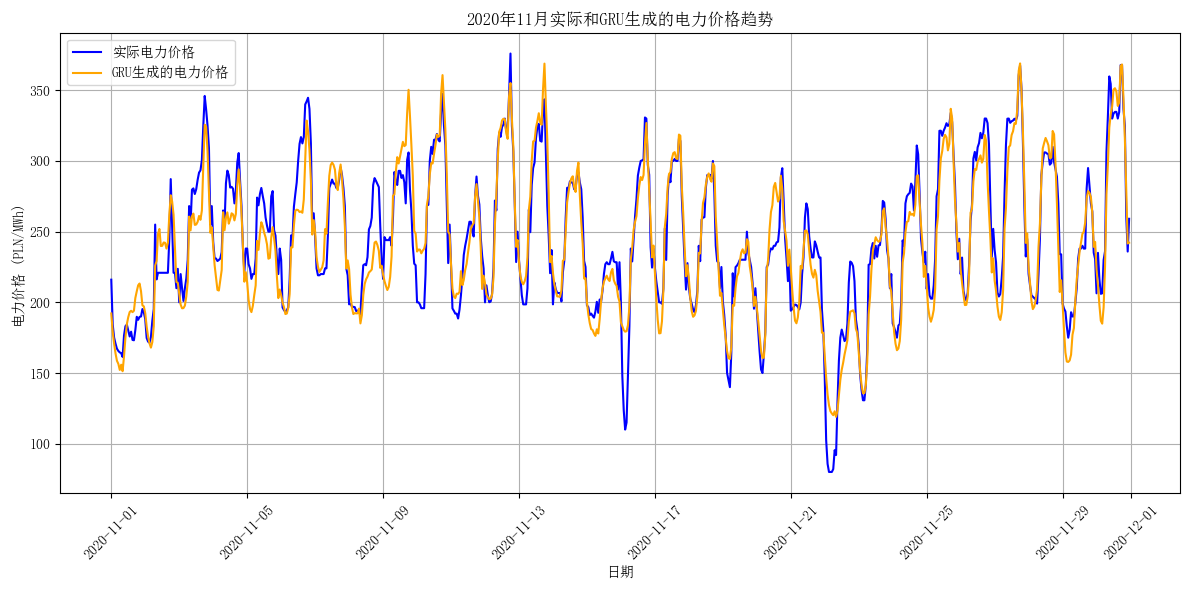

In [26]:
# 筛选出2020年11月的数据
november_data = df_pred['2020-11-01':'2020-11-30']

# 提取实际电力价格和GRU生成的电力价格
actual_prices = november_data['electricity_price (PLN/MWh)']
predicted_prices = november_data['model forecast']

# 创建日期索引
dates = november_data.index

# 绘制电力价格趋势图
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='实际电力价格', color='blue')
plt.plot(dates, predicted_prices, label='GRU生成的电力价格', color='orange')
plt.xlabel('日期')
plt.ylabel('电力价格 (PLN/MWh)')
plt.title('2020年11月实际和GRU生成的电力价格趋势')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


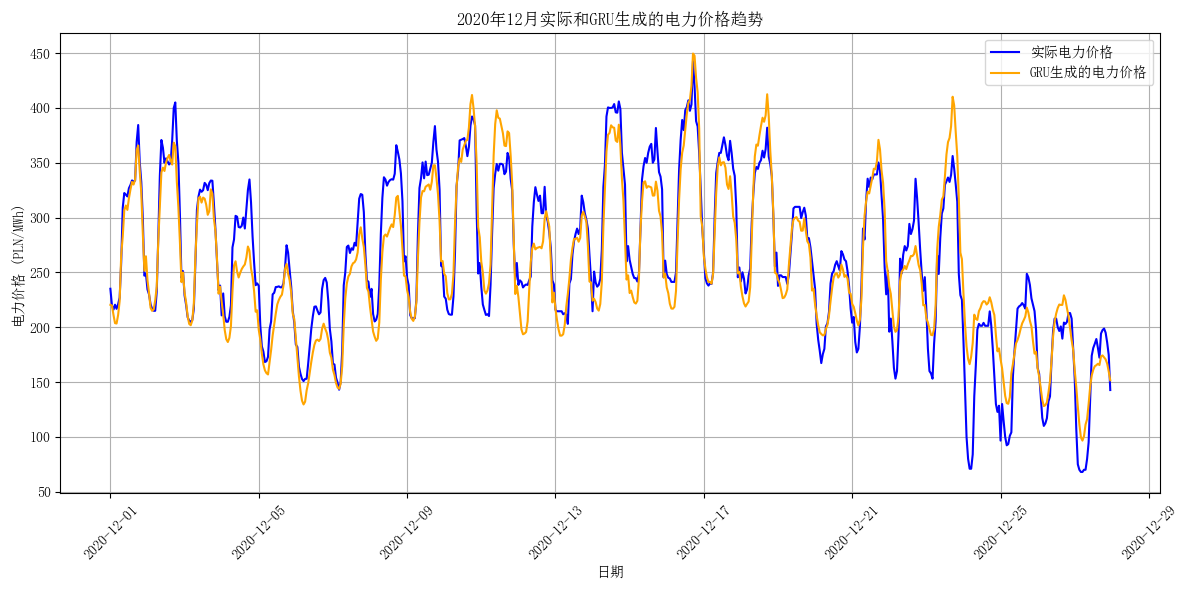

In [27]:
import matplotlib.pyplot as plt

# 筛选出2020年12月的数据
december_data = df_pred['2020-12-01':'2020-12-31']

# 提取实际电力价格和GRU生成的电力价格
actual_prices = december_data['electricity_price (PLN/MWh)']
predicted_prices = december_data['model forecast']

# 创建日期索引
dates = december_data.index

# 绘制电力价格趋势图
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='实际电力价格', color='blue')
plt.plot(dates, predicted_prices, label='GRU生成的电力价格', color='orange')
plt.xlabel('日期')
plt.ylabel('电力价格 (PLN/MWh)')
plt.title('2020年12月实际和GRU生成的电力价格趋势')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


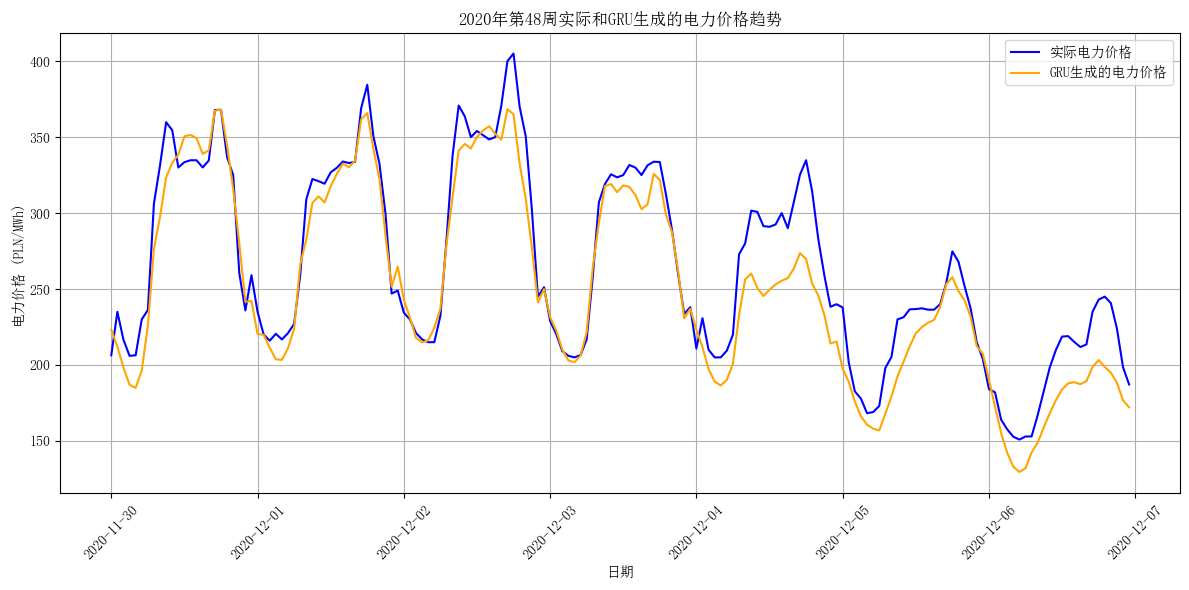

In [28]:
import matplotlib.pyplot as plt

# 筛选出2020年第48周的数据
week48_data = df_pred['2020-11-30':'2020-12-06']

# 提取实际电力价格和GRU生成的电力价格
actual_prices = week48_data['electricity_price (PLN/MWh)']
predicted_prices = week48_data['model forecast']

# 创建日期索引
dates = week48_data.index

# 绘制电力价格趋势图
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='实际电力价格',color='blue')
plt.plot(dates, predicted_prices, label='GRU生成的电力价格', color='orange')
plt.xlabel('日期')
plt.ylabel('电力价格 (PLN/MWh)')
plt.title('2020年第48周实际和GRU生成的电力价格趋势')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
